In [270]:
using CSV
using Glob
using DataFrames
using Statistics

using Plots
using Plots.PlotMeasures
using StatsPlots, KernelDensity


In [271]:
#cd("/vf/users/saakyanh2/WD/fx/foldexity")
include("../src/foldexity.jl")
include("../src/entropy.jl")


# Folding entropy

In [ ]:
folding = "ubiq2"
folding_trajpdb = "../../mdfolding/pdbtraj_$folding"
rms = CSV.read("../../mdfolding/$folding.dat", DataFrame, header=["f", "d"], skipto=3)

b, e, o = 3000, 6000, 1

x = rms.d[b:o:e] 

print(length(x))

plot(b:o:e, x, seriestype = :scatter, 
    size=(600, 250), markersize = 2, alpha = 0.5, margins = 5mm,
    label="RMSD", xlabel = "Time", ylabel="RMSD (Å)")


In [273]:
cpptraj("../../mdfolding/$folding.pdb", 
        "../../mdfolding/traj100_$folding.xtc", b, e, o,
        folding_trajpdb)

In [ ]:
traj3di = structure2fs3di(folding_trajpdb)
traj3di = traj3di[!, [:id, :seqaa, :seq3di]]
transform!(traj3di, :id => ByRow(s -> parse(Int, split(basename(s),".")[1])) => :id)
sort!(traj3di, :id)
size(traj3di)

In [ ]:
trajmu = structure2rsmu(folding_trajpdb)
transform!(trajmu, :id => ByRow(s -> parse(Int, split(basename(s),"_")[1])) => :id)
sort!(trajmu, :id)
size(trajmu)

In [297]:
k=1
traj3di[!,:H1_fold ] = entropy_shannon.(traj3di.seq3di, k)
traj3di[!,:lz ] = lz76.(traj3di.seq3di, k)
trajmu[!,:H1_fold ] = entropy_shannon.(trajmu.seq, k)
trajmu[!,:lz ] = lz76.(trajmu.seq, k)
size(trajmu)

(3001, 4)

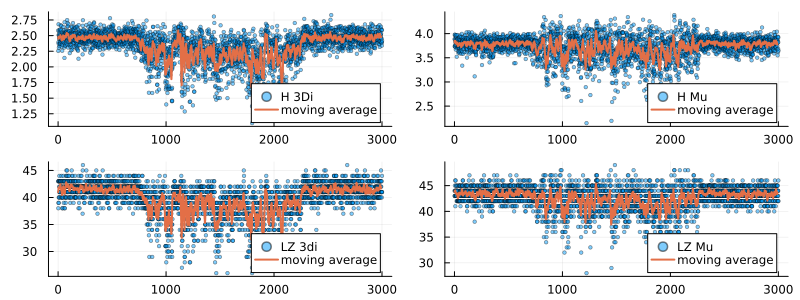

In [294]:
function pltdots(x, label, mk=2, alpha=.5, wsize=10)
    
    moving_average = [mean(x[i:i+wsize]) for i in 1:length(x)-wsize]

    p = plot(x, seriestype = :scatter, markersize = mk, alpha = alpha, label=label)
    p = plot!(moving_average, linewidth = 2, alpha = 1, label="moving average")

    return p
end

p1 = pltdots(traj3di.H1_fold, "H 3Di")
p2 = pltdots(trajmu.H1_fold, "H Mu")
p3 = pltdots(traj3di.lz, "LZ 3di" )
p4 = pltdots(trajmu.lz, "LZ Mu")

plot(p1, p2, p3, p4, layout = (2,2), size = (800, 300))

In [ ]:
fxdir(folding_trajpdb, "fxdata.tsv", 6, "knn", 1)
fx = CSV.read("fxdata.tsv", DataFrame, delim = "\t") ; rm("fxdata.tsv")
transform!(fx, :pdbpath => ByRow(s -> parse(Int, split(basename(s),".")[1])) => :id)
sort!(fx, :id)
fxknn = fx

size(fx)


In [ ]:
fxdir(folding_trajpdb, "fxdata.tsv", 3, "seq", 0.8)
fx = CSV.read("fxdata.tsv", DataFrame, delim = "\t") ; rm("fxdata.tsv")
transform!(fx, :pdbpath => ByRow(s -> parse(Int, split(basename(s),".")[1])) => :id)
sort!(fx, :id)
fxseq = fx

size(fx)

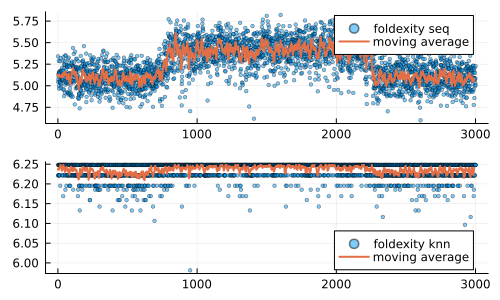

In [301]:
p1 = pltdots(fxseq.fxity, "foldexity seq")
p2 = pltdots(fxknn.fxity, "foldexity knn")
plot(p1, p2, layout=(2,1), size = (500, 300))

In [ ]:
scatter(x, fxseq.fxity)